In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score
import umap

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
folder_path = r"C:\Users\tere1\OneDrive\Escritorio\TFM\datos_img"
# Cargar las características normalizadas por Z-score
df_combined_ft_z = pd.read_csv(os.path.join(folder_path, "features_combined_ft_zscore.csv"))
# Cargar las características normalizadas por Min-Max
df_combined_ft_mm = pd.read_csv(os.path.join(folder_path, "features_combined_ft_minmax.csv"))

#se quitan las columnas 'filename' y 'label'
df_combined_ft_mm_cl= df_combined_ft_mm.drop(columns=['label', 'filename'])
df_combined_ft_z_cl= df_combined_ft_z.drop(columns=[ 'label', 'filename'])

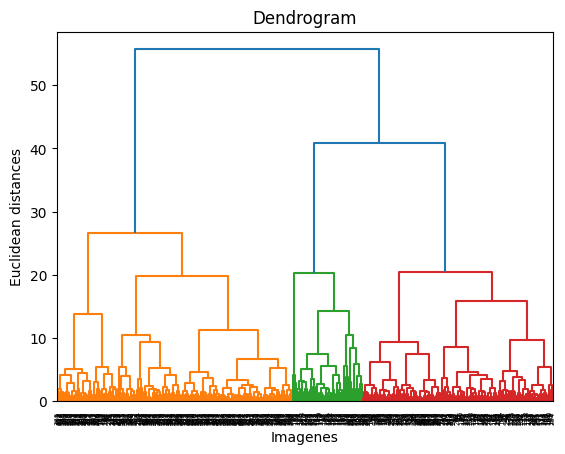

In [3]:
# Using the dendrogram to find the optimal number of clusters
dendrogram = sch.dendrogram(sch.linkage(df_combined_ft_z_cl, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Imagenes')
plt.ylabel('Euclidean distances')
plt.show()

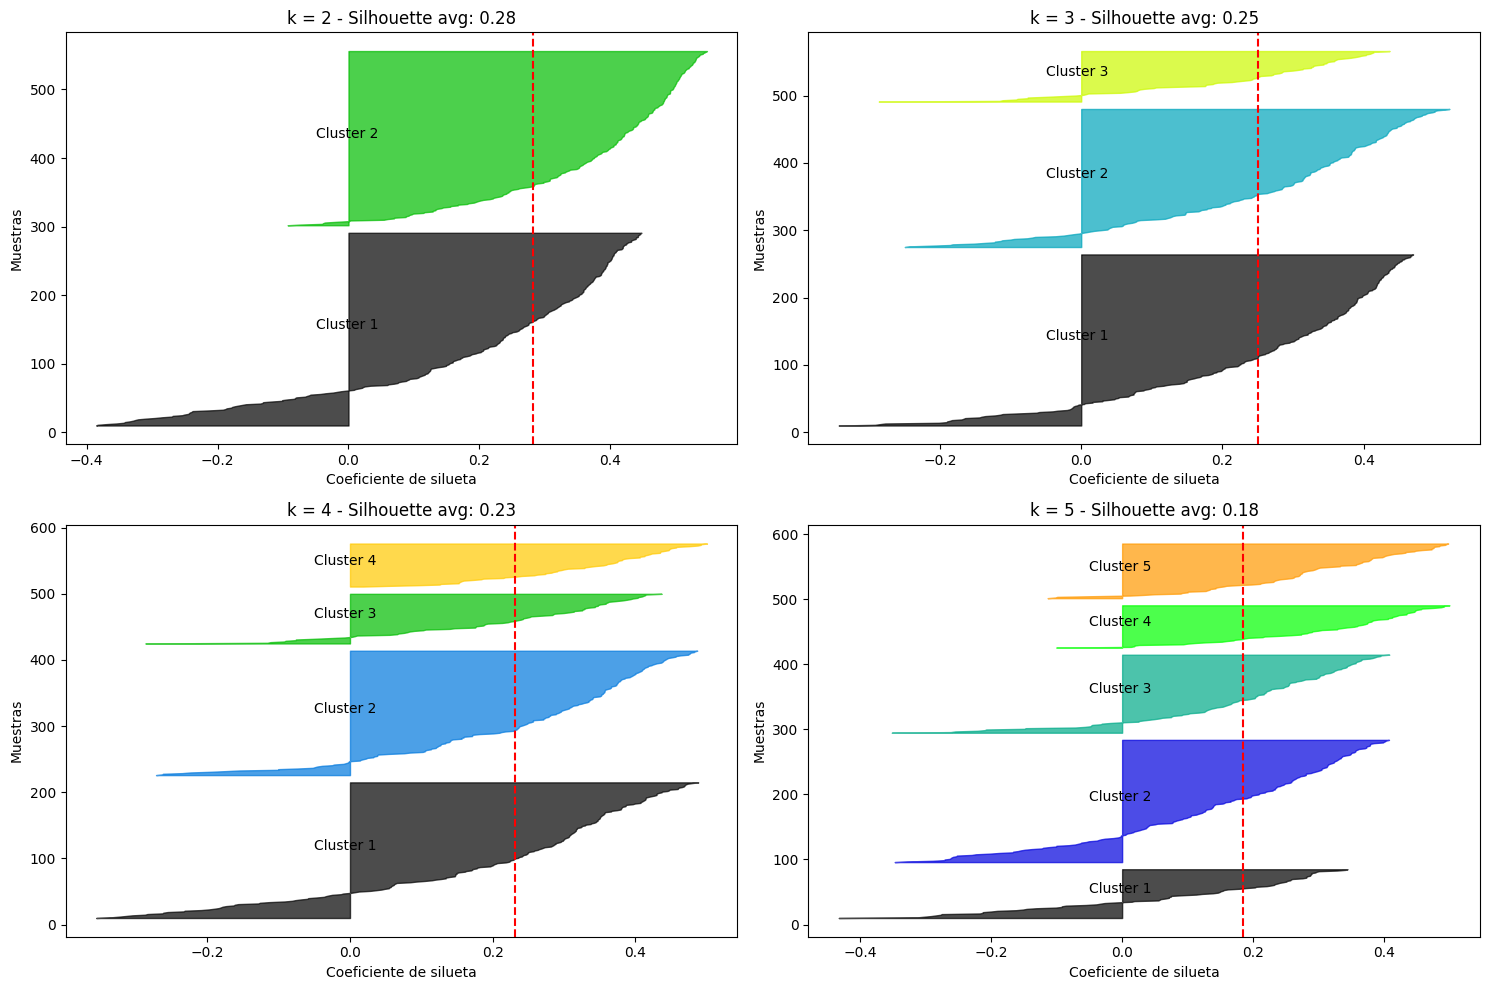

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Probar con 2, 3, 4 y 5 clusters
for i, k in enumerate([2, 3, 4, 5]):
    clusterer = AgglomerativeClustering(n_clusters=k, linkage='ward', metric='euclidean')
    labels = clusterer.fit_predict(df_combined_ft_z_cl)
    silhouette_vals = silhouette_samples(df_combined_ft_z_cl, labels)
    silhouette_avg = silhouette_score(df_combined_ft_z_cl, labels)

    # Subplot row/col
    row = i // 2
    col = i % 2
    ax_i = ax[row][col]
    y_lower = 10

    for j in range(k):
        j_silhouette_vals = silhouette_vals[labels == j]
        j_silhouette_vals.sort()
        size = len(j_silhouette_vals)
        y_upper = y_lower + size
        color = cm.nipy_spectral(float(j) / k)
        ax_i.fill_betweenx(np.arange(y_lower, y_upper), 0, j_silhouette_vals,
                           facecolor=color, edgecolor=color, alpha=0.7)
        ax_i.text(-0.05, y_lower + size / 2, f'Cluster {j+1}')
        y_lower = y_upper + 10

    ax_i.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax_i.set_title(f'k = {k} - Silhouette avg: {silhouette_avg:.2f}')
    ax_i.set_xlabel("Coeficiente de silueta")
    ax_i.set_ylabel("Muestras")

plt.tight_layout()
plt.show()

In [5]:
hc_z = AgglomerativeClustering(n_clusters = 2, metric = 'euclidean', linkage = 'ward')
y_hc_z = hc_z.fit_predict(df_combined_ft_z_cl)


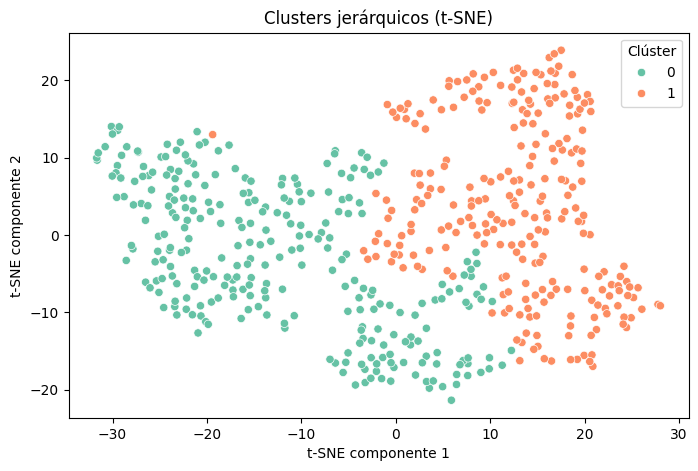

       label  cluster
0    smaller        0
1    smaller        1
2    smaller        0
3    smaller        0
4    smaller        0
..       ...      ...
532   higher        1
533   higher        1
534   higher        1
535   higher        1
536   higher        1

[537 rows x 2 columns]


In [6]:
#Visualización alternativa con t-SNE (
tsne_z = TSNE(n_components=2, random_state=42)
X_tsne_z = tsne_z.fit_transform(df_combined_ft_z_cl)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_tsne_z[:, 0], y=X_tsne_z[:, 1], hue=y_hc_z, palette='Set2')
plt.title('Clusters jerárquicos (t-SNE)')
plt.xlabel('t-SNE componente 1')
plt.ylabel('t-SNE componente 2')
plt.legend(title='Clúster')
plt.show()

df_resultado_z = pd.DataFrame({

    'label': df_combined_ft_z['label'],
    'cluster': y_hc_z
})

print(df_resultado_z)

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


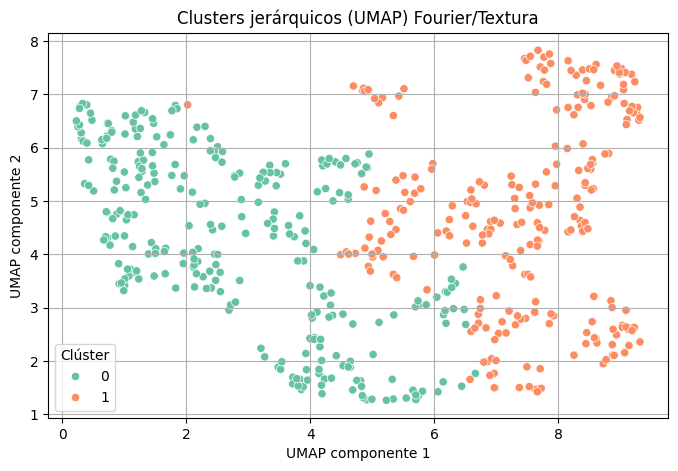

In [7]:
umap_z = umap.UMAP(n_neighbors=15,n_components=2, random_state=42)
X_umap_z = umap_z.fit_transform(df_combined_ft_z_cl)


plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_umap_z[:, 0], y=X_umap_z[:, 1], hue=y_hc_z, palette='Set2')
plt.title('Clusters jerárquicos (UMAP) Fourier/Textura')
plt.xlabel('UMAP componente 1')
plt.ylabel('UMAP componente 2')
plt.legend(title='Clúster')
plt.grid(True)
plt.show()

In [8]:
# Crear la tabla de contingencia entre 'label' y 'cluster'
contingency_table = pd.crosstab(df_resultado_z['label'], df_resultado_z['cluster'])

# Mostrar la tabla de contingencia
print(contingency_table)

cluster    0    1
label            
higher    52  216
smaller  230   39


In [9]:
# y_hc_z son las etiquetas del clustering, df_fourier_z_cl los datos
score = silhouette_score(df_combined_ft_z_cl, y_hc_z)
print(f'Silhouette Score: {score:.3f}')


Silhouette Score: 0.282


El 80.59% de las imágenes etiquetadas como 'higher' están en el cluster 1 y las imágenes etiquetadas como 'smaller', el 85.50% están en el cluster 0. La silueta es baja por lo que estos dos clusteres están muy próximos y además, los puntos dentro de ellos no se encuentran cercanos.

min-max

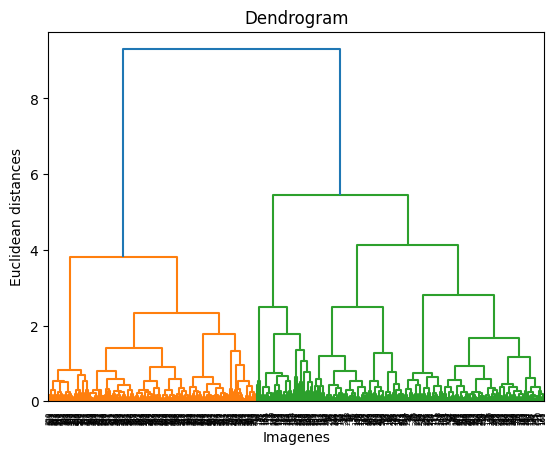

In [10]:
# Using the dendrogram to find the optimal number of clusters
dendrogram = sch.dendrogram(sch.linkage(df_combined_ft_mm_cl, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Imagenes')
plt.ylabel('Euclidean distances')
plt.show()

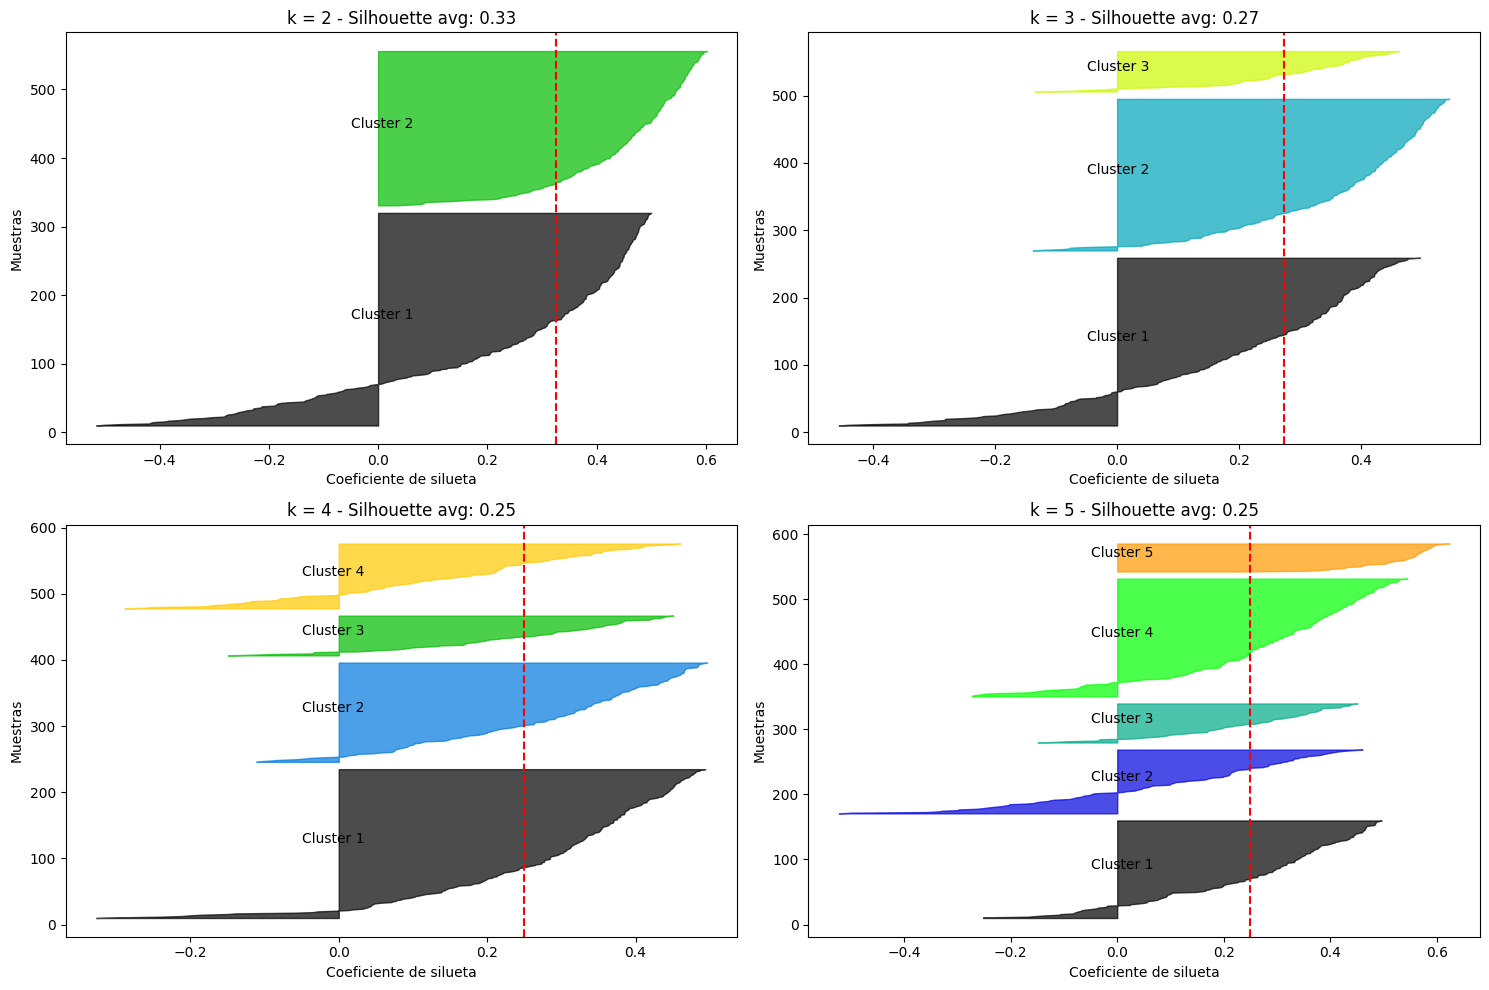

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

# Probar con 2, 3, 4 y 5 clusters
for i, k in enumerate([2, 3, 4, 5]):
    clusterer = AgglomerativeClustering(n_clusters=k, linkage='ward', metric='euclidean')
    labels = clusterer.fit_predict(df_combined_ft_mm_cl)
    silhouette_vals = silhouette_samples(df_combined_ft_mm_cl, labels)
    silhouette_avg = silhouette_score(df_combined_ft_mm_cl, labels)

    # Subplot row/col
    row = i // 2
    col = i % 2
    ax_i = ax[row][col]
    y_lower = 10

    for j in range(k):
        j_silhouette_vals = silhouette_vals[labels == j]
        j_silhouette_vals.sort()
        size = len(j_silhouette_vals)
        y_upper = y_lower + size
        color = cm.nipy_spectral(float(j) / k)
        ax_i.fill_betweenx(np.arange(y_lower, y_upper), 0, j_silhouette_vals,
                           facecolor=color, edgecolor=color, alpha=0.7)
        ax_i.text(-0.05, y_lower + size / 2, f'Cluster {j+1}')
        y_lower = y_upper + 10

    ax_i.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax_i.set_title(f'k = {k} - Silhouette avg: {silhouette_avg:.2f}')
    ax_i.set_xlabel("Coeficiente de silueta")
    ax_i.set_ylabel("Muestras")

plt.tight_layout()
plt.show()

In [12]:
hc_mm = AgglomerativeClustering(n_clusters = 2, metric = 'euclidean', linkage = 'ward')
y_hc_mm = hc_mm.fit_predict(df_combined_ft_mm_cl)

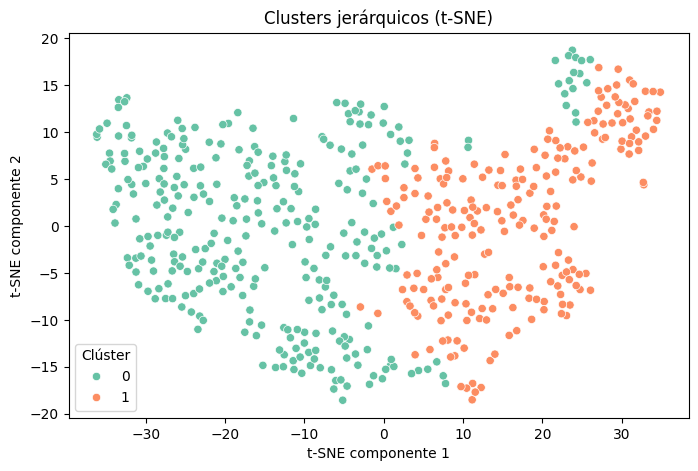

       label  cluster
0    smaller        0
1    smaller        0
2    smaller        0
3    smaller        0
4    smaller        0
..       ...      ...
532   higher        1
533   higher        1
534   higher        1
535   higher        1
536   higher        1

[537 rows x 2 columns]


In [13]:
#Visualización alternativa con t-SNE (
tsne_mm = TSNE(n_components=2, random_state=42)
X_tsne_mm = tsne_mm.fit_transform(df_combined_ft_mm_cl)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_tsne_mm[:, 0], y=X_tsne_mm[:, 1], hue=y_hc_mm, palette='Set2')
plt.title('Clusters jerárquicos (t-SNE)')
plt.xlabel('t-SNE componente 1')
plt.ylabel('t-SNE componente 2')
plt.legend(title='Clúster')
plt.show()

df_resultado_mm = pd.DataFrame({
    
    'label': df_combined_ft_mm['label'],
    'cluster': y_hc_mm
})

print(df_resultado_mm)

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


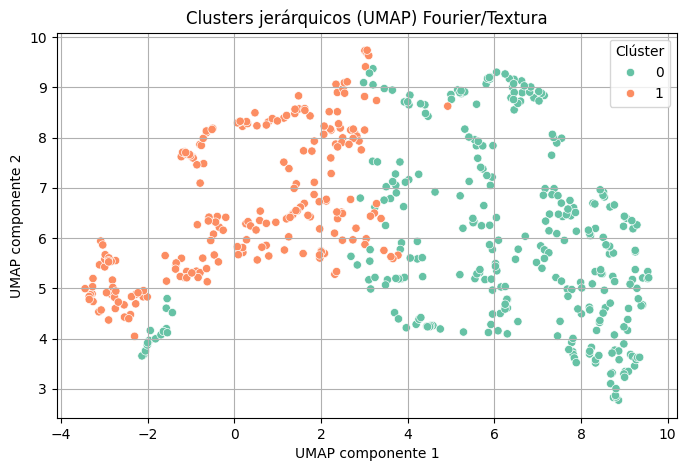

In [14]:
umap_mm = umap.UMAP(n_neighbors=10,n_components=2, random_state=42)
X_umap_mm = umap_mm.fit_transform(df_combined_ft_mm_cl)


plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_umap_mm[:, 0], y=X_umap_mm[:, 1], hue=y_hc_mm, palette='Set2')
plt.title('Clusters jerárquicos (UMAP) Fourier/Textura')
plt.xlabel('UMAP componente 1')
plt.ylabel('UMAP componente 2')
plt.legend(title='Clúster')
plt.grid(True)
plt.show()

In [15]:
# Crear la tabla de contingencia entre 'label' y 'cluster'
contingency_table = pd.crosstab(df_resultado_mm['label'], df_resultado_mm['cluster'])

# Mostrar la tabla de contingencia
print(contingency_table)

cluster    0    1
label            
higher    59  209
smaller  252   17


In [16]:
# y_hc_z son las etiquetas del clustering, df_fourier_z_cl los datos
score = silhouette_score(df_combined_ft_mm_cl, y_hc_mm)
print(f'Silhouette Score: {score:.3f}')

Silhouette Score: 0.326


aplicar umap para reducir la dimensionalidad 

c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\tere1\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\tere1\AppData\Local\Temp\ipykernel_21736\2348761799.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_umap_mm_umap[:, 0], X_umap_mm_umap[:, 1], cmap='Spectral', edgecolor='k', alpha=0.7)


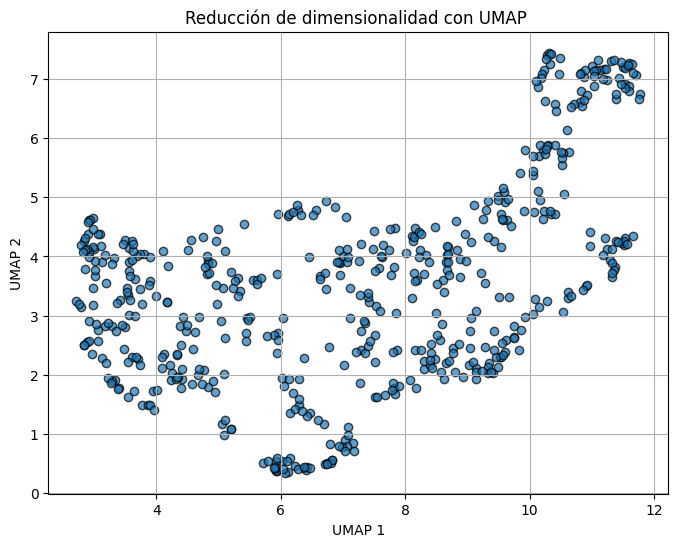

In [17]:
# Aplicar UMAP a los datos ya estandarizados y sin columnas no numéricas
umap_mm_umap = umap.UMAP(n_neighbors=13,n_components=6, random_state=42) #10
X_umap_mm_umap = umap_mm_umap.fit_transform(df_combined_ft_mm_cl)

# Visualizar los resultados de UMAP
plt.figure(figsize=(8, 6))
plt.scatter(X_umap_mm_umap[:, 0], X_umap_mm_umap[:, 1], cmap='Spectral', edgecolor='k', alpha=0.7)
plt.title('Reducción de dimensionalidad con UMAP ')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.show()



In [18]:
hc_mm_umap = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'ward')
y_hc_mm_umap = hc_mm_umap.fit_predict(X_umap_mm_umap)

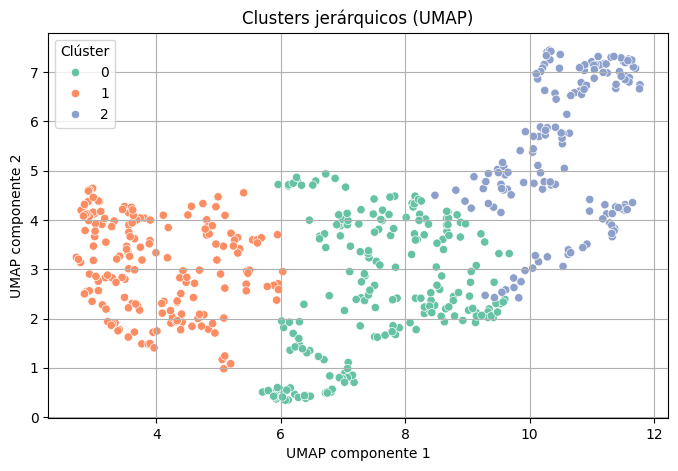

In [19]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_umap_mm_umap[:, 0], y=X_umap_mm_umap[:, 1], hue=y_hc_mm_umap, palette='Set2')
plt.title('Clusters jerárquicos (UMAP)')
plt.xlabel('UMAP componente 1')
plt.ylabel('UMAP componente 2')
plt.legend(title='Clúster')
plt.grid(True)
plt.show()

In [20]:


score_mm_umap = silhouette_score(X_umap_mm_umap, y_hc_mm_umap)
print(f"Puntuación de silueta: {score_mm_umap:.3f}")



Puntuación de silueta: 0.449


In [21]:
true_labels_mm = df_combined_ft_mm['label']  
predicted_labels_umap_mm = y_hc_mm_umap

# Crear la tabla
contingency_table_umap_mm = pd.crosstab(true_labels_mm, predicted_labels_umap_mm)

# Mostrar
print(contingency_table_umap_mm)

col_0      0    1    2
label                 
higher   122    3  143
smaller   85  176    8


con tres clusteres hay una mejor reparticion. cuando se usan dos clusteres en un cluster hay muchos smaller y en el otro una mezcla de higher y smaller
con tres clusteres hay un cluster con más higher, otro con más smaller y otro con mezcla.